# Quiz 5

## Name
## NetID

We will use a dataset known as the "Pima Indians" dataset. This data observes the diabetes status of members of the Pima tribe. You will have a few variables to work with:

* Number of times pregnant.

* Plasma glucose concentration a 2 hours in an oral glucose tolerance test.

* Diastolic blood pressure (mm Hg).

* Triceps skinfold thickness (mm).

* 2-Hour serum insulin (mu U/ml).

* Body mass index (weight in kg/(height in m)^2).

* Diabetes pedigree function.

* Age (years).

* Class variable Diabetic or Not (0 or 1).



The cell below imports the data, the variables are ordered the same as above

The url is here:

"https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"

df=pd.read_csv(url, names=['preg', 'plas',
                          'bp', 'thick',
                          'insulin', 'bmi',
                          'diaped','age', 'diab'])

We would like to be able to predict diabetes from this dataset. We will use random forests to make sure we can accomplish this task. You will do a few things:


* Check if the classes are balanced

* If the classes are imbalanced use one of the techniques we talked about in class to ameliorate the problem. Check if you do better by just running a model with no hyperparameter assignment to compare.

* Do a train test split and draw a ROC curve using the default values for the random forest classifier. What is the AUC?

* Set the number of trees to 100 and use 5 fold cross-validation and the AUC to look for the best value for max_depth

**Suggested Answer:**

Let's first observe our class balance. We simply need to see if the number of people marked diabetic are the same as those marked non-diabetic.

In [4]:
df['diab'].value_counts()

0    500
1    268
Name: diab, dtype: int64

As you can see the dataset has about twice the number of non-diabetics as diabetics. Let's just do simple upsampling of the underrepresented class. 

In [19]:
#Let me first import everything I will use below

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve


In [5]:
# Separate majority and minority classes

df_majority = df[df['diab']==0]

df_minority = df[df['diab']==1]

Let's upsample the minority until we have the same number of observations (500)

In [8]:
df_minority_up = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=500,   
                                 random_state=42) 
 

Let's consolidate the upsampled dataframe:

In [9]:
df_up=pd.concat([df_majority, df_minority_up])

We can now use random forests with no hyperparameters on the original dataframe and on the upsampled dataset and compare the classification reports. Let's just create a list of features first to make things easier:

In [10]:
features=['preg', 'plas',
            'bp', 'thick',
        'insulin', 'bmi',
        'diaped','age']

In [11]:
#These are the predictions from the unbalanced dataframe

pred=RandomForestClassifier().fit(
    X=df[features],
    y=df['diab']).predict(df[features])

#Add them as a column in your data
df['pred']=pred

#These are the upsampled predictions

predup=RandomForestClassifier().fit(
    X=df_up[features],
    y=df_up['diab']).predict(df_up[features])

#add them as a column in your upsampled dataframe
df_up['pred']=predup


Now let's look at the classification report of the imbalanced data:

In [12]:
print(classification_report(y_pred=df['pred'],
                            y_true=df['diab']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [14]:
print(classification_report(y_pred=df_up['pred'],
                            y_true=df_up['diab']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



This is unusual, but it seems that with all the information we gave the random forest classifier, both datasets perform perfectly with a probability threshold of 0.5. However, this might simply be overfitting. Let's try using the initial unbalanced dataframe since we don't see much of a loss of model accuracy when using random forests.

In [17]:
X=df[features]
y=df['diab']

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=0)



We will check the AUC for predicting diabetics correctly (when the label is 1)

In [23]:
rf_clf=RandomForestClassifier()
y_score = rf_clf.fit(X_train, 
                     y_train).predict_proba(X_test)

#Since we want label 1

y_proba=y_score[:,1]

#Now compute the roc auc and the tpf and fpr

fpr, tpr , threshold= roc_curve(y_test,  y_proba)

#get the auc score
auc=roc_auc_score(y_test, y_proba)


Let's put everything in a single dataframe to plot, and let's make the plot!

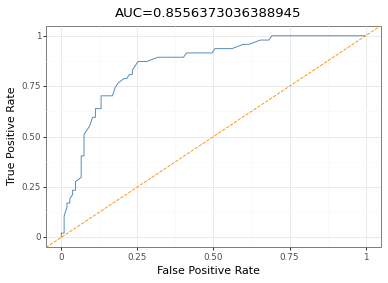

<ggplot: (8786141056145)>

In [24]:
results=pd.DataFrame({'fpr':fpr,'tpr':tpr,
                      'threshold':threshold})

#Plot

(ggplot(data=results, mapping=aes(x='fpr', y='tpr'))+
geom_line(color='steelblue')+
ggtitle(f'AUC={auc}')+
geom_abline(linetype='dashed', color='darkorange')+
 ylab("True Positive Rate")+
 xlab("False Positive Rate")+
 theme_bw()
)

Hey! That's pretty great! Let's look for the optimal number of splits by searching the cross-validation AUC scores. I will use 5 folds. I will try up to 14 branchings.


In [25]:
scoresrf=[cross_val_score(RandomForestClassifier(n_estimators=100,
                                 max_depth=i),X,y,
                          scoring="roc_auc",
                          cv=5).mean() for i in list(range(1,15))
    ]

Let's save all these scores in a dataframe to then plot them:

In [26]:
rfdf=pd.DataFrame(scoresrf, columns=['AUC'])
rfdf['depth']=range(1,15)

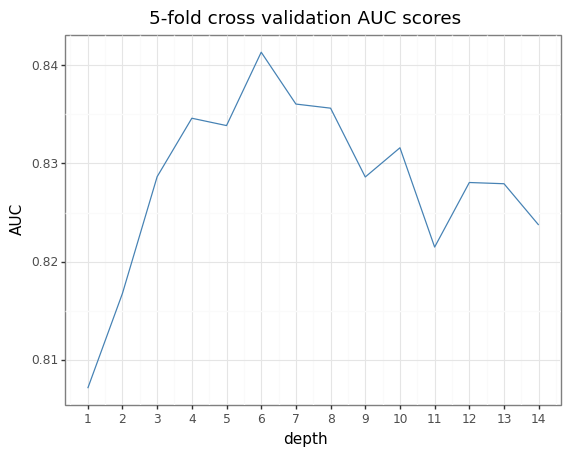

<ggplot: (8786119047834)>

In [27]:
#Let's plot this!

(ggplot(data=rfdf, mapping=aes(x='depth', y='AUC'))+
       geom_line(color='steelblue')+
 scale_x_continuous(breaks=np.arange(1,15, 1))+
 ggtitle('5-fold cross validation AUC scores')+
theme_bw())

Let's get the optimal depth (you can see from the plot it's 6):

In [28]:
rfdf.loc[rfdf['AUC']==rfdf['AUC'].max(),:]

,AUC,depth
5,0.841325,6
